# Models
The general idea is to fit a model to the behavioural data of a subject, once only with information about the presented motion direction and criterion direction in each trial, the **experimental design (ED) model**, and once with an EEG-derived measure of the brain representation of the presented motion direction (together with the exact presented criterion direction), the **EEG model**. We then want to investigate whether the EEG model fits the behavioural data better than the ED model and the HDDM.

The ED model gets the actual value of the presented motion direction as a constant input. At every time step noise is added to this true motion direction and the ED model then integrates these noisy observations of motion direction to replicate variance in RT and choice for trials with the same true motion direction (and criterion). This is the basic mechanism which is also implemented in the DDM (if we were modelling motion direction judgements).

The EEG model gets *EEG channel responses*, one for each considered motion direction, as input. The channel responses are directly integrated as evidence for a particular motion direction. Through the noisiness of the EEG this model input carries its own source of variability. The main idea is that this variability in the EEG data explains a bit more of the variability of the behaviour than the completely random noise added in the ED model.

## Parameters
Following the above described mechanism the ED model has the following main parameters:
- `intstd`: subject's internal uncertainty about observations of motion direction, the higher,
  the slower and more accurate evidence accumulation should be
- `noisestd`: amount of noise added to motion direction observations; the higher, the faster and less accurate evidence accumulation should be
- `bound`: confidence bound that needs to be reached before subject makes a decision (typically 
  fixed to 0.7)
- `bias`: a response bias towards either clockwise or counter-clockwise choices
- `ndtloc`: log of lower bound of uniform non-decision time distribution; the lower, the smaller
  the non-decision time
- `lapseprob`: lapse probability, i.e. probability with which subject makes completely random
  choices with 0.5 choice probability and uniform RT distribution over the whole allowed range

The EEG model shares the same parameters. Following the description above the `noisestd` shouldn't be necessary. I still tested things allowing `noisestd > 0` which should have the effect that information in the EEG variability is washed out. This could be beneficial, when there are other signals in the EEG that are not relevant to the decision about motion direction. In tests with subject 18 I found that having `noisestd > 0` makes parts of the model unidentifiable (some correlation between noisestd and intstd in the posterior parameter distribution). I also found that fixing `noisestd = 0` leads to at least as good fit to the behaviour as having `noisestd` vary. I, therefore, fixed `noisestd = 0` in the EEG model for the inference on all subjects.

# Goodness of fit
To determine how well a model explains the behavioural data I use posterior predictive sampling. Specifically, inference with a model gives me a posterior parameter distribution for each subject that supposedly describes the behaviour of the subjects. I sample 2000 parameter sets from this distribution and then use the model to generate 2000 behavioural data sets for the trials of that subject. Then I can compare the sampled data sets to the observed one.

## Summary statistics
When inferring model parameters from data, I use summary statistics to compare sampled and observed data sets. The summary statistics I use are RT histograms: I use a fixed set of RT bins and then compute the fraction of clockwise responses falling into each bin separately for easy and hard trials. So these statistics summarise a data set of, e.g., 2000 trials as, in my case, 14 fractions. This is also how the DDM has typically been fit to data.

## Deviance
My comparison measure is a form of deviance or error, i.e., something based on the difference between sampled and observed. When $S$ is the number of samples from the posterior, $B$ the number of summary statistic bins, $\hat{f}_{s, b}$ is the fraction of clockwise responses in summary statistic bin $b$ of sample $s$ and $f_b$ is the fraction of clockwise responses in the observed data, my deviance measure is:
$$
D = \frac{1}{S}\sum_{s=1}^S \underset{b \in \{1,\dots,B\}}{\mathrm{median}}\left|\hat{f}_{s, b} - f_b\right|.
$$
Alternatively, we can replace the median above with the sum of squared errors and get a form of mean squared error:
$$
\mathrm{MSE} = \frac{1}{S}\sum_{s=1}^S \sum_{b=1}^B \left(\hat{f}_{s, b} - f_b\right)^2.
$$
The MSE equally summarises the goodness of fit across all summary statistic bins while D ignores large deviations in few bins.

# Results

## Model comparison
In the following figure each vertical tick line represents the difference between goodness of fit for the indicated model and the EEG model for one subject. This means that positive values favour the EEG model in this subject and negative values the other model (because then the EEG model has larger D or MSE). The smooth lines are density estimates across subjects and indicate whether one model is better than the other on the group level. Additionally, I have added t-values of the hypothesis test for whether the shown values are different from 0 in the legends.

For the deviance D the EEG model tends to be better than the HDDM across subjects, but there is no evidence that the EEG model explains the behaviour of the subjects better than the ED model. For the MSE the trend is the same, but much less prominent, with models exhibiting more similar performance. The negative t-values for the MSE are driven by the two outlier subjects where the EEG model is clearly worse than the two other models.

In [54]:
%matplotlib notebook
import os
from glob import glob
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import helpers
import snl_simulators as snlsim

fit = pd.read_hdf('figures/goodness_of_fit.h5', 'fit')

In [112]:
model = 'ED'
measure = 'MSE'
diffs = fit.loc[:, (measure, model)] - fit.loc[:, (measure, 'EEG')]
diffs.sort_values()

subject
35   -0.064775
19   -0.033712
5    -0.004723
4    -0.004506
15   -0.004442
11   -0.003365
2    -0.002874
17   -0.001893
24   -0.001657
30   -0.001388
14   -0.001378
8    -0.001028
12   -0.000670
3    -0.000079
20   -0.000012
34    0.000185
21    0.000467
28    0.000499
13    0.000678
18    0.000725
32    0.000796
31    0.000860
27    0.001871
26    0.002061
6     0.002140
16    0.002340
29    0.002364
22    0.003324
7     0.004306
23    0.010940
33    0.050066
dtype: float64

<IPython.core.display.Javascript object>


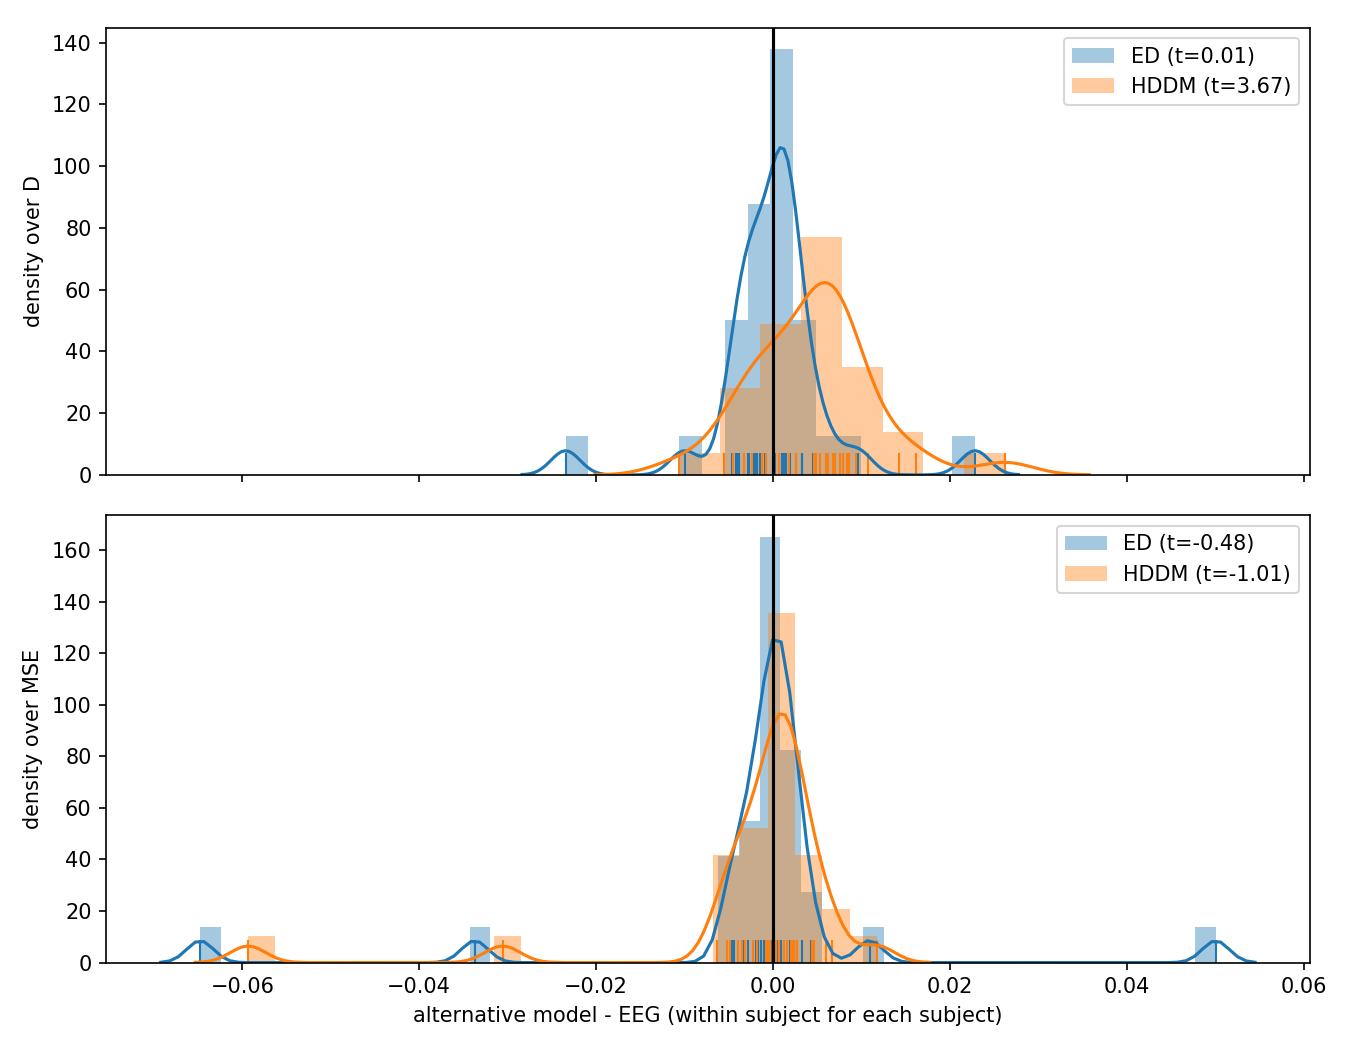

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 7))

for ax, measure in zip(axes, ['D', 'MSE']):
    for model in ['ED', 'HDDM']:
        diffs = fit.loc[:, (measure, model)] - fit.loc[:, (measure, 'EEG')]
        tval = np.mean(diffs) / (np.std(diffs) / np.sqrt(len(diffs)))
        sns.distplot(diffs, label='{} (t={:.2f})'.format(model, tval), rug=True, ax=ax)
        
    ax.set_ylabel('density over {}'.format(measure))
    ax.legend()
    
for ax in axes:
    ax.set_autoscaley_on(False)
    ax.plot([0, 0], ax.get_ylim(), 'k')
    
ax.set_xlabel('alternative model - EEG (within subject for each subject)')
fig.tight_layout()

## Comparison of parameter values between ED and EEG

In [67]:
results = {
        'ED': os.path.join(
                helpers.resultsdir, 'snl', 'rotated_directions', '201807061824'),
        'EEG': os.path.join(
                helpers.resultsdir, 'snl', 'rotated_directions', '201907240843')}
stats = 'hist'

subjects = [int(os.path.basename(f)[1:3]) 
            for f in glob(os.path.join(results['EEG'], '*%s.log' % stats))]
subjects = sorted(subjects)[:-1]

def get_params(sub, result):
    psamples = pd.read_hdf(os.path.join(result, 's%02d_%s.h5' % (sub, stats)), 'parameters')
    
    R = psamples.index.get_level_values('round').unique().max()
    
    params = snlsim.create_default_params(psamples.columns)
    
    parvals = params.transform(psamples.loc[R].values)
    
    return pd.DataFrame(parvals, columns=psamples.columns).describe()

pars = pd.concat(
        [pd.concat([get_params(sub, results[model]) for sub in subjects],
                    keys=subjects, names=['subject', 'measure'])
         for model in ['ED', 'EEG']], axis=1, keys=['ED', 'EEG'], names=['model', 'param'])

In [124]:
def compare_param(par, sub=None):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    
    parvals = pars.loc[(slice(None), 'mean'), (slice(None), par)]
    
    # assumes uniform non-decision times with ndtloc log of lower bound (default)
    if par == 'ndtloc':
        parvals = np.exp(parvals)
    
    for model, color in zip(['ED', 'EEG'], ['C0', 'C1']):
        sns.distplot(parvals[model],
                     rug=True, color=color, label=model, ax=axes[0])
        
    axes[0].legend()
    axes[0].set_title(par)
    axes[0].set_ylabel('density')
    axes[0].set_xlabel('mean posterior value (per subject)')

    sns.distplot(parvals['ED'] - parvals['EEG'],
                 rug=True, color='C2', label='ED - EEG', ax=axes[1])
    
    if sub is not None:
        yl = axes[0].get_ylim()
        for model, color in zip(['ED', 'EEG'], ['C0', 'C1']):
            axes[0].plot(parvals.loc[sub, model].values[0] * np.r_[1, 1],
                         [0, yl[1] / 3.], '--', color=color)
            
        yl = axes[1].get_ylim()
        axes[1].plot((parvals.loc[sub, 'ED'] - parvals.loc[sub, 'EEG']).values[0] * np.r_[1, 1],
                     [0, yl[1] / 3.], '--', color='C2', label='subject %s' % sub)
    
    axes[1].legend();

    fig.tight_layout()
    
    return fig, axes

In [144]:
highlightsub = diffs.sort_values().index[0]
highlightsub

35

The following figures show for one parameter, respectively, the mean posterior value for each subject for the two models. The right panels show the within-subject difference of these parameter values.

### intstd
The values for the intstd were rather similar in the two models. This is quite interesting, but probably arbitrary as it depends on the scaling of the input noise, i.e., on noisestd in the ED model and the channel responses in the EEG model. I normalised the EEG channel responses to standard deviation = 1 within subject. So this should be close to the scale of the noisestd in the ED model.

<IPython.core.display.Javascript object>


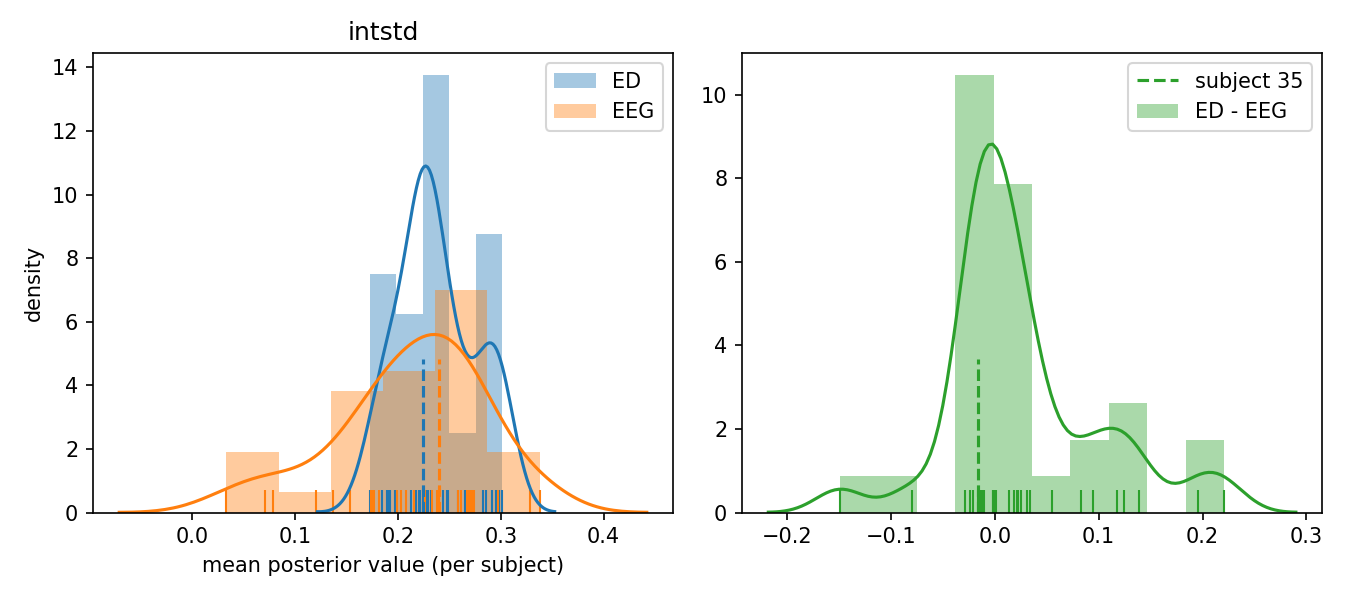

In [145]:
fig, axes = compare_param('intstd', highlightsub)

### bias
The EEG model indicates a clear bias towards clockwise rotations across subjects whereas the ED model has only rather low biases around 0.5. Don't know where this comes from.

<IPython.core.display.Javascript object>


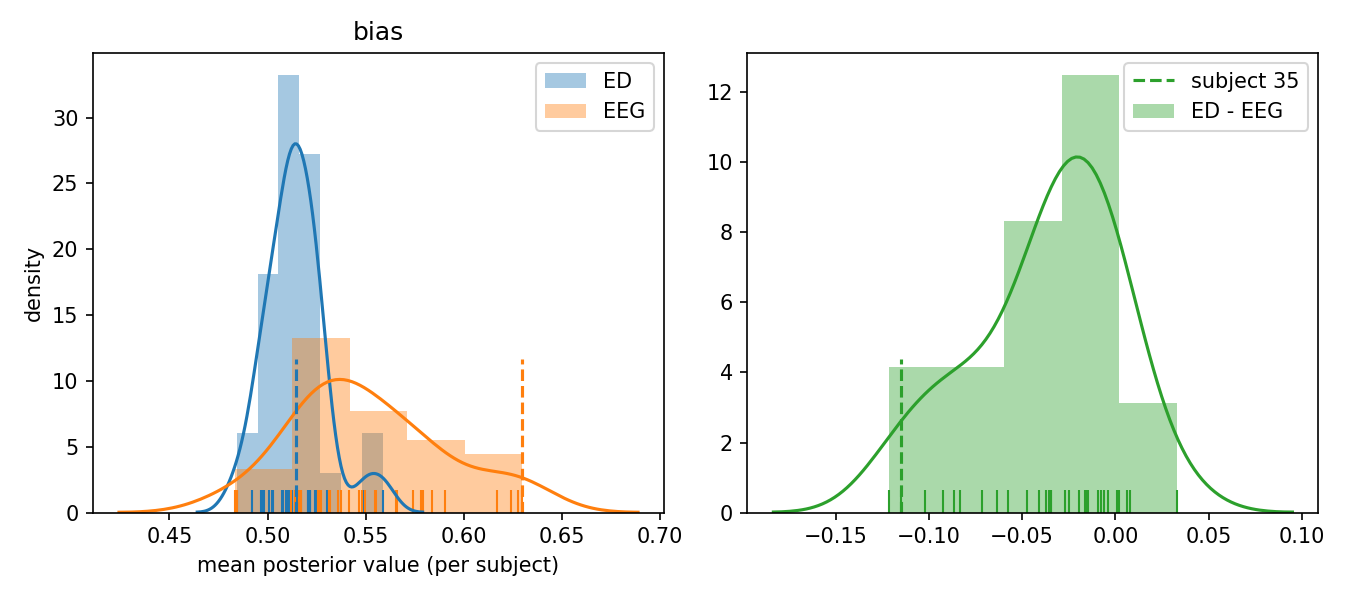

In [146]:
fig, axes = compare_param('bias', highlightsub)

### ndtloc
This is the lower bound of the uniform non-decision time distribution, i.e., non-decision times added by the model to the RTs will be at least this high. The EEG model clearly exhibits longer non-decision times (about 50 to 200 ms longer on average). This means that the EEG model uses its decision making mechanism based on the EEG input to explain only a smaller part of the RTs than the ED model. In other words, this result suggests that decisions are made faster in the EEG model than in the ED model and the EEG model explains the RTs with a greater proportion of non-decision time.

In the worst case the EEG model only uses the very first sample from the channel response to make the decision and then just adds a random non-decision time to it. But that cannot be, because the fit to the RT distribution is ok and intstd, which is the major determiner of how fast decisions are made, is similar between ED and EEG. So the faster decision times should be driven by the specifics of the EEG input.

<IPython.core.display.Javascript object>


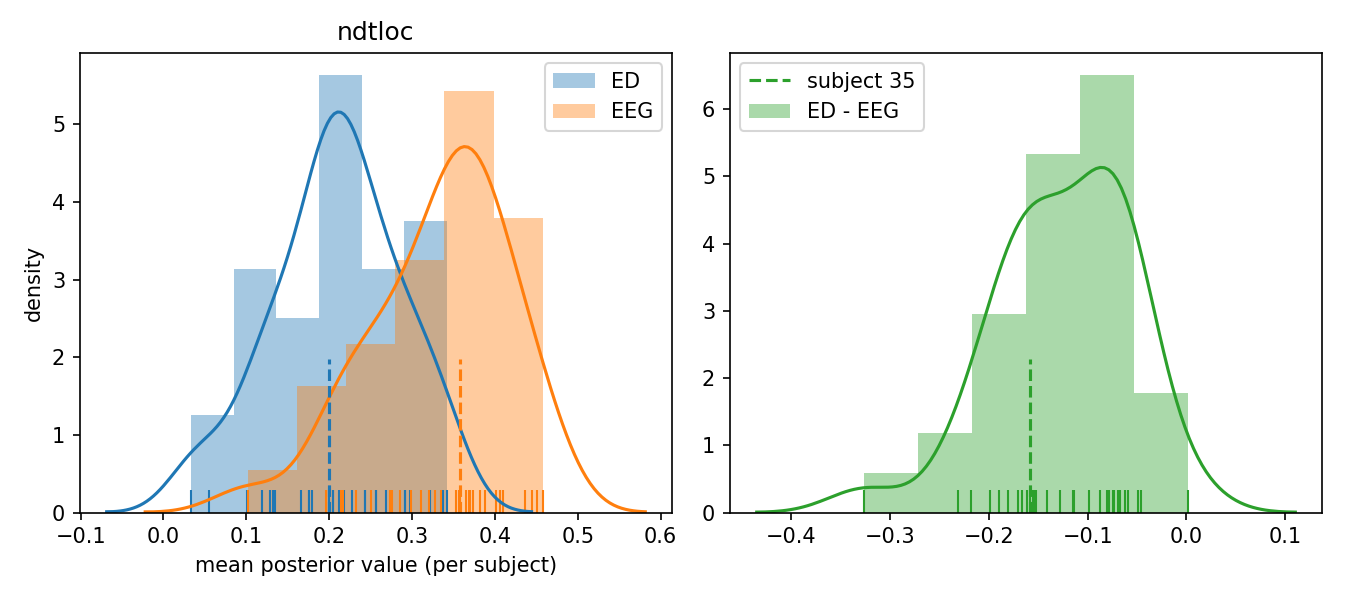

In [147]:
fig, axes = compare_param('ndtloc', highlightsub)

### lapseprob
Lapse probabilities are clearly higher in the EEG model (for some subjects above 30%) than in the ED model. This means that the model actually explains fewer responses with the decision process and more as purely random choices. Again, as the posterior fits of the two models are pretty similar, it's not possible to tell whether the one or the other interpretation (high or low lapses) is a better description of the data.

<IPython.core.display.Javascript object>


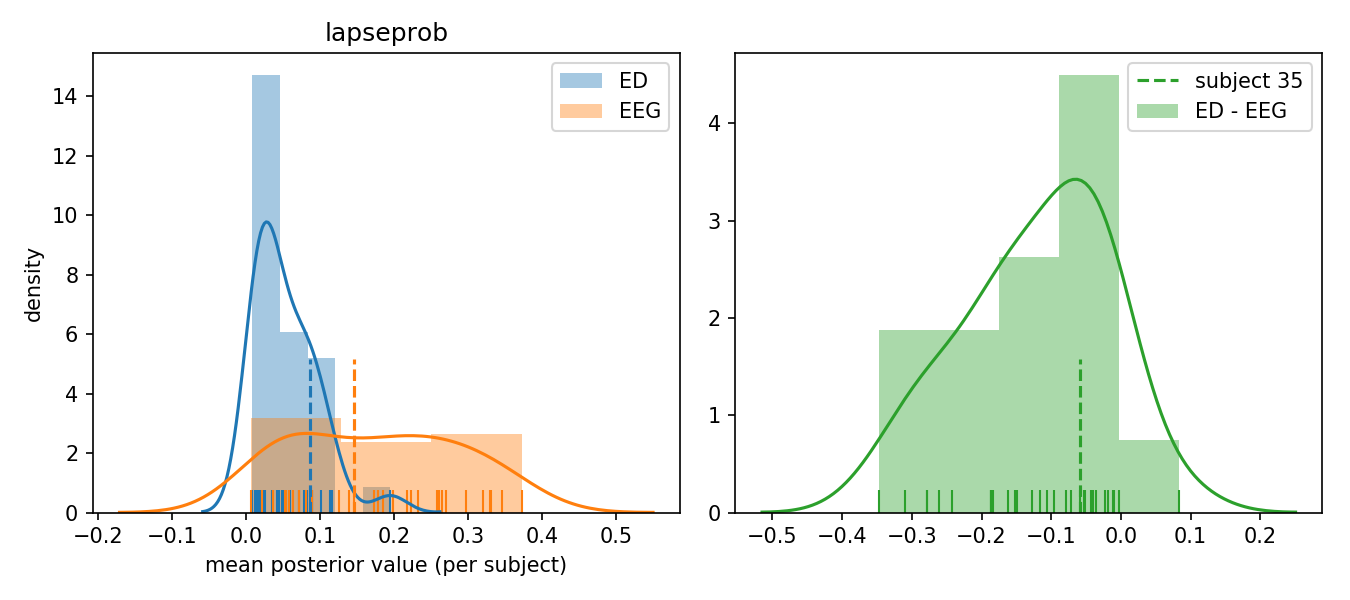

In [148]:
fig, axes = compare_param('lapseprob', highlightsub)

# Parameters and easy vs. hard decisions
In the models a decision is made, when the confidence in one of the alternatives reaches the bound. The confidence here is the estimated probability with which a clockwise or anti-clockwise rotation is correct given the observed motion direction samples. Intuitively, in easy decisions the probabilities of the two options should diverge faster than in harder decisions so that easy decisions have faster RTs, but also higher accuracy. The model automatically implements this, because the posterior beliefs estimated by the model about the currently observed motion direction are the same for easy and hard decisions, but in easy decisions the corresponding probability distribution covers one of the rotation options more clearly than the other. Here's an illustration:

<IPython.core.display.Javascript object>


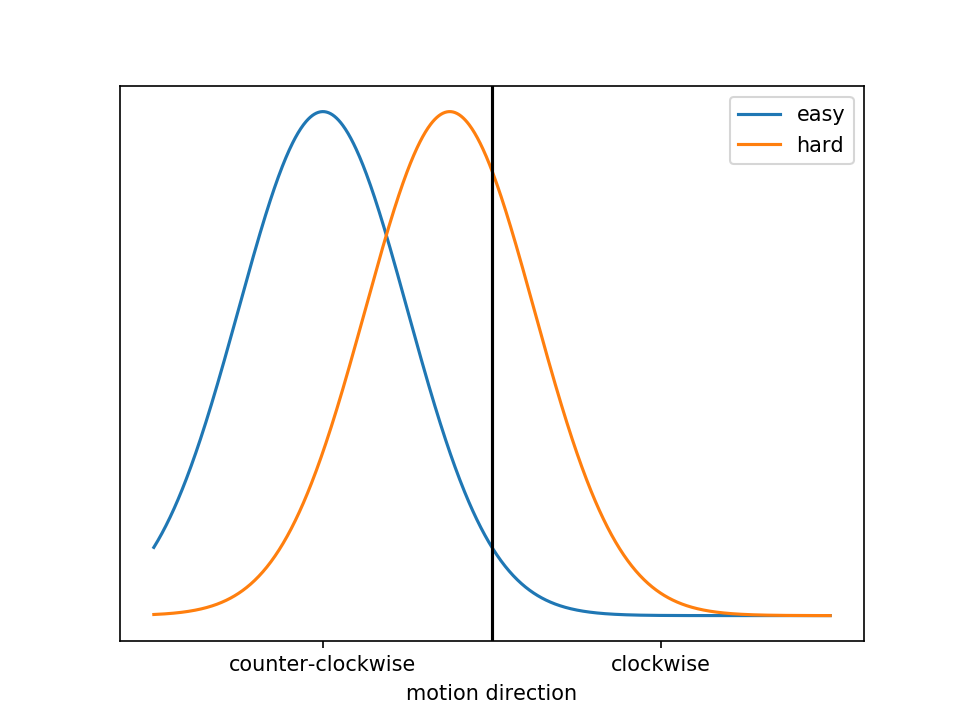

In [166]:
xx = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots()
ax.plot(xx, stats.norm.pdf(xx, -2), label='easy')
ax.plot(xx, stats.norm.pdf(xx, -0.5), label='hard')
ax.set_autoscaley_on(False)
ax.plot([0, 0], ax.get_ylim(), 'k')
ax.legend()
ax.set_xticks([-2, 2])
ax.set_xticklabels(['counter-clockwise', 'clockwise']);
ax.set_yticks([]);
ax.set_xlabel('motion direction');

# Next steps
- similar parameters for ED and EEG?
- parameter changes
- which parameter accounts for differences in easy-hard? (conceptual)
- what is going on with the outliers in MSE?